In [ ]:
!pip install rasterio
!pip install sat-search
!pip install intake-stac
!pip install geopandas
!pip install geojson
!pip install rioxarray
!pip install rasterstats
!pip install earthpy
# *If you use Google Colaboratery, after installing the libraries, please restart the runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ライブラリ読み込み
from osgeo import gdal, gdalconst, gdal_array
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from rasterio.crs import CRS
import rioxarray as rxr
from shapely.geometry import MultiPolygon, Polygon, box
import rasterstats as rs
import earthpy.spatial as es
import earthpy.plot as ep
import random
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from fiona.crs import from_epsg
import json
import io
import requests
import intake
from satsearch import Search
%matplotlib inline
plt.rcParams['figure.dpi'] = 250

In [ ]:
#画像サイズに合わせて数値を設定します
offx = 0
offy = 0
cols = 4000
rows = 7200

# ファイルの場所は適宜変えて下さい
tif = gdal.Open('/content/drive/MyDrive/playground/satBooks/shizuokaTreeHeight/Izu.tif', gdalconst.GA_ReadOnly)
izuimg = tif.GetRasterBand(1).ReadAsArray(offx, offy, cols, rows)

# 画像データの値に合わせて設定します
plt.figure(figsize = (6,12))
plt.imshow(izuimg,cmap='gray', vmin = 0, vmax = 53, interpolation = 'none')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#画像サイズに合わせて数値を設定します
offx = 0
offy = 0
cols = 4000
rows = 7200

# ファイルの場所は適宜変えて下さい
tif = gdal.Open('/content/drive/MyDrive/playground/satBooks/shizuokaTreeHeight/Izu.tif', gdalconst.GA_ReadOnly)
izuimg = tif.GetRasterBand(1).ReadAsArray(offx, offy, cols, rows)

# 画像データの値に合わせて設定します
plt.figure(figsize = (6,12))
plt.imshow(izuimg,cmap='gray', vmin = 0, vmax = 53, interpolation = 'none')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ds = gdal.Open("/content/drive/MyDrive/playground/satBooks/shizuokaTreeHeight/Izu.tif")

# reproject
dsReprj = gdal.Warp("/content/drive/MyDrive/IzuReprj.tif", ds, dstSRS = "EPSG:32654")

# resample 5m->10m
# 現在の作業ディレクトリにファイルを保存
dsRes = gdal.Warp("/content/drive/MyDrive/IzuResMean.tif", dsReprj, xRes = 10, yRes = 10, resampleAlg = "average") # リサンプリング後の解像度 (10m)
# dsRes = gdal.Warp("IzuResNear.tif", dsReprj, xRes = 10, yRes = 10, resampleAlg = "near") # リサンプリング後の解像度 (10m)

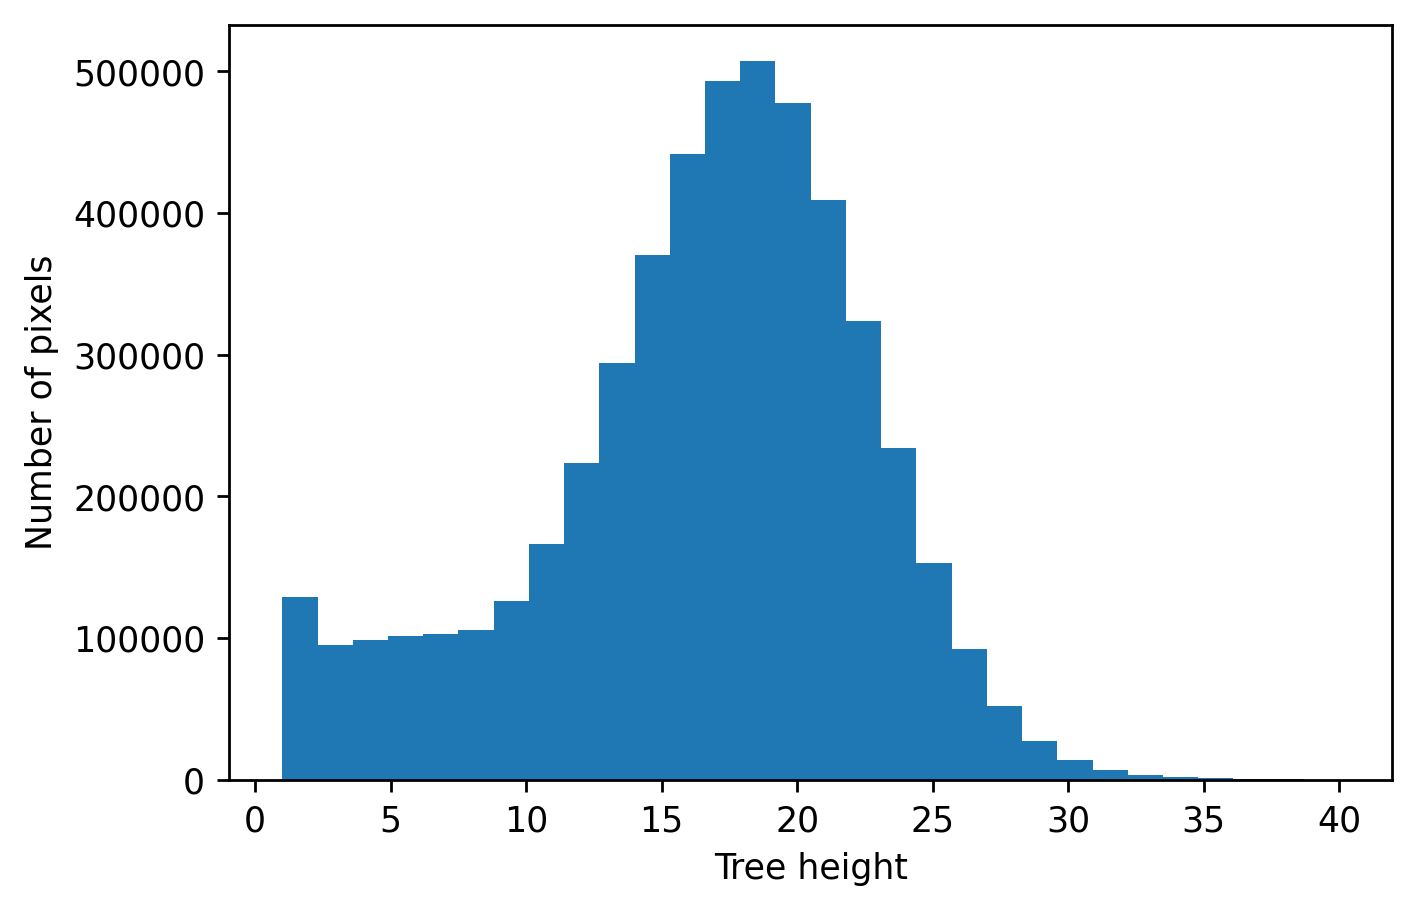

In [ ]:
#樹高データ
dsres_arr = dsRes.GetRasterBand(1).ReadAsArray()
# print(dsres_arr) #樹高データの結果確認

#分布を確認(ヒストグラム)
tree_height_data = dsres_arr.flatten()

plt.xlabel('Tree height')
plt.ylabel('Number of pixels')
plt.hist(tree_height_data.ravel(),30,[1,40]) # 1m以上以上40m以下
plt.show()

In [ ]:
# 伊豆半島に西側を関心領域に設定する
from IPython.display import IFrame
src = 'https://www.keene.edu/campus/maps/tool/'
IFrame(src, width=960, height=500)

## Import用
# 138.7339597, 34.9782520
# 138.7312132, 34.8002724
# 138.8987502, 34.8081657
# 138.8877641, 34.9748762
# 138.7339597, 34.9782520

In [ ]:
aoi = [
      [
        138.7339597,
        34.978252
      ],
      [
        138.7312132,
        34.8002724
      ],
      [
        138.8987502,
        34.8081657
      ],
      [
        138.8877641,
        34.9748762
      ],
      [
        138.7339597,
        34.978252
      ]
    ]

In [ ]:
# 関心領域の最小緯度・経度、最大緯度・経度を取得します
areaLon = []
areaLat = []
# iterating each number in list
for coordinate in aoi:
  areaLon.append(coordinate[0])
  areaLat.append(coordinate[1])

minLon = np.min(areaLon) # min longitude
maxLon = np.max(areaLon) # max longitude
minLat = np.min(areaLat) # min latitude
maxLat = np.max(areaLat) # max latitude

In [ ]:
bbox = [minLon, minLat, maxLon, maxLat] # 画像取得範囲の設定 min lon, min lat, max lon, max lat
dates = '2020-01-01/2020-12-31'

URL='https://earth-search.aws.element84.com/v0'
results = Search.search(url=URL,
                        collections=['sentinel-s2-l2a-cogs'], # sentinel-s2-l1c, sentinel-s2-l2a-cogs, sentinel-s2-l2aが指定できます
                        datetime=dates,
                        bbox=bbox,    
                        sort=['<datetime'])

In [ ]:
print('%s items' % results.found()) #検索で取得したデータ数を表示
items = results.items()
items.save('sentinel-s2-l2a-cogs.json') #結果はJSONへ保存

146 items


In [ ]:
catalog = intake.open_stac_item_collection(items) #取得結果のカタログ化。画像のダウンロード用に用います
gf = gpd.read_file('/content/sentinel-s2-l2a-cogs.json')
# 雲量で並び替え
gfSroted = gf.sort_values('eo:cloud_cover').reset_index(drop=True)
gfSroted.head()

,id,datetime,platform,constellation,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,data_coverage,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,geometry
0,S2B_54SUD_20201223_0_L2A,2020-12-23T01:37:33+00:00,sentinel-2b,sentinel-2,10,0,32654,54,S,NaN,UD,0,S2B_MSIL2A_20201223T013049_N0214_R074_T54SUD_2...,100.0,0.00,True,2020-12-26T01:09:12.361000+00:00,2020-12-26T01:09:12.361000+00:00,"POLYGON ((138.82851 34.23370, 138.80247 35.223..."
1,S2A_54STD_20200502_0_L2A,2020-05-02T01:37:43+00:00,sentinel-2a,sentinel-2,10,0,32654,54,S,100.0,TD,0,S2A_MSIL2A_20200502T012701_N0214_R074_T54STD_2...,100.0,0.00,True,2020-09-19T00:36:59.661999+00:00,2020-09-19T00:36:59.661999+00:00,"POLYGON ((137.74383 34.20968, 137.70483 35.198..."
2,S2B_54STD_20201024_0_L2A,2020-10-24T01:37:43+00:00,sentinel-2b,sentinel-2,10,0,32654,54,S,NaN,TD,0,S2B_MSIL2A_20201024T012729_N0214_R074_T54STD_2...,100.0,0.00,False,2020-10-24T09:12:25.261999+00:00,2020-10-24T09:12:25.261999+00:00,"POLYGON ((137.74383 34.20968, 137.70483 35.198..."
3,S2B_54SUD_20201024_0_L2A,2020-10-24T01:37:40+00:00,sentinel-2b,sentinel-2,10,0,32654,54,S,NaN,UD,0,S2B_MSIL2A_20201024T012729_N0214_R074_T54SUD_2...,100.0,0.00,False,2020-10-24T09:15:52.592999+00:00,2020-10-24T09:15:52.592999+00:00,"POLYGON ((138.82851 34.23370, 138.80247 35.223..."
4,S2A_54STD_20201208_0_L2A,2020-12-08T01:37:37+00:00,sentinel-2a,sentinel-2,10,0,32654,54,S,NaN,TD,0,S2A_MSIL2A_20201208T013041_N0214_R074_T54STD_2...,100.0,0.01,True,2020-12-08T06:35:20.063999+00:00,2020-12-08T06:35:20.063999+00:00,"POLYGON ((137.74383 34.20968, 137.70483 35.198..."


['overview', 'thumbnail', 'metadata', 'B11', 'B01', 'B12', 'B02', 'B03', 'B04', 'AOT', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'WVP', 'visual', 'SCL', 'info']


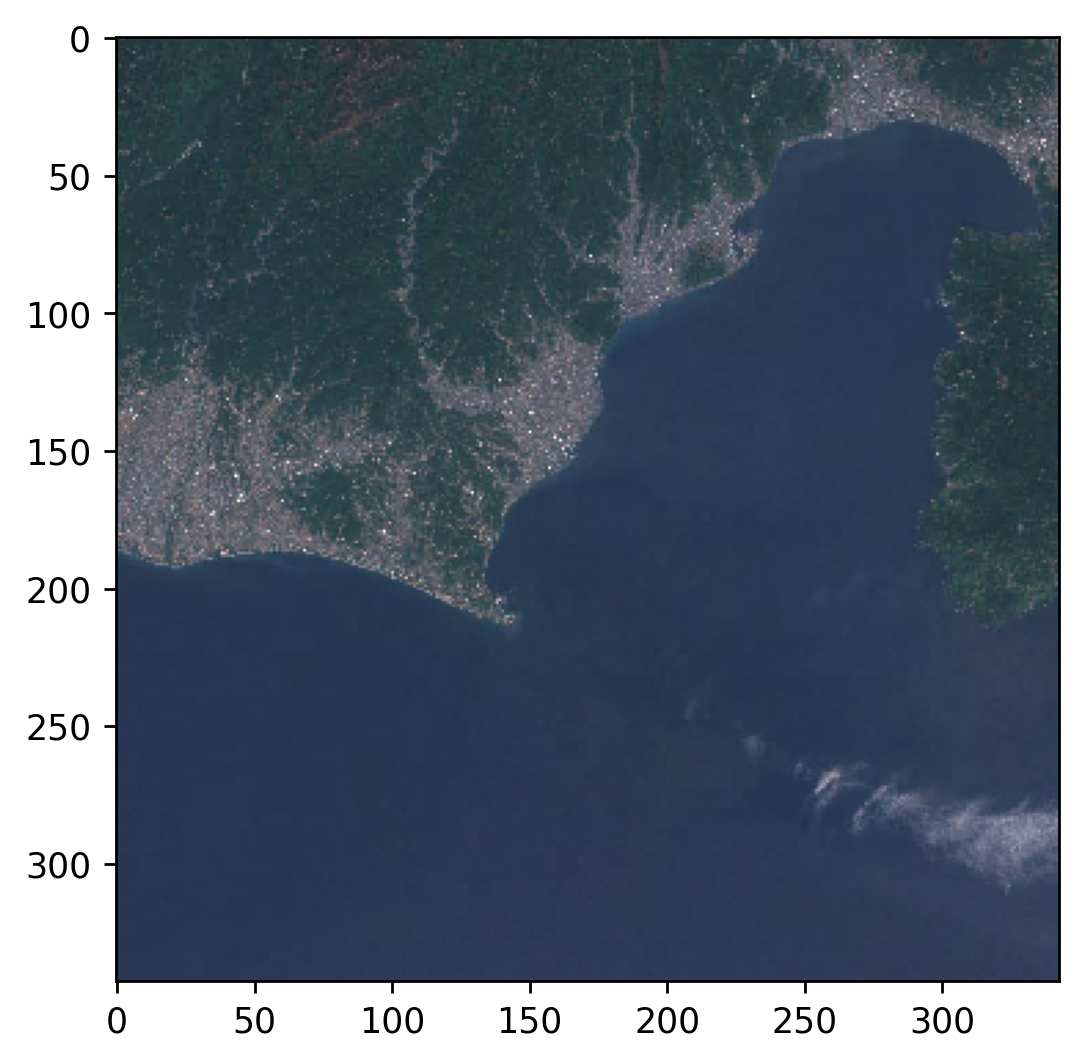

In [ ]:
# 雲の量が最も少ない画像を取得
item = catalog[gfSroted.id[1]]

# 画像に含まれるデータを確認します
# 手動でダウンロードしたものと同じバンド情報が入っていることがわかります
print(list(item))

# サムネイル画像の表示（RGB画像）
thumb_url = item['thumbnail'].urlpath
thumbImg = Image.open(io.BytesIO(requests.get(thumb_url).content))

plt.figure(figsize=(5,5))
plt.imshow(thumbImg)

In [ ]:
# NDVIを作成するために赤バンドと近赤外バンドのデータを取得
bandLists = ['B04','B08']
file_url = [item[band].metadata['href'] for band in bandLists]
print(file_url)

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/TD/2020/5/S2A_54STD_20200502_0_L2A/B04.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/TD/2020/5/S2A_54STD_20200502_0_L2A/B08.tif']


wgetを用いて静岡県の行政界データをダウンロードします。

In [ ]:
!wget --restrict-file-names=nocontrol \
     --content-disposition \
     --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Gecko/20100101 Firefox/52.0" \
     "https://opendata.pref.shizuoka.jp/fs/2/4/5/2/6/_/____35___.zip"

--2022-11-05 11:20:57--  https://opendata.pref.shizuoka.jp/fs/2/4/5/2/6/_/____35___.zip
Resolving opendata.pref.shizuoka.jp (opendata.pref.shizuoka.jp)... 153.122.123.151
Connecting to opendata.pref.shizuoka.jp (opendata.pref.shizuoka.jp)|153.122.123.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2722988 (2.6M) [application/zip]
Saving to: ‘合併後(35市町).zip’

合併後(35市町).zip  100%[===================>]   2.60M  1.58MB/s    in 1.6s    

2022-11-05 11:20:59 (1.58 MB/s) - ‘合併後(35市町).zip’ saved [2722988/2722988]



In [ ]:
with zipfile.ZipFile('/content/合併後(35市町).zip') as zipf:
  for zinfo in zipf.infolist():        # ZipInfoオブジェクトを取得
      if not zinfo.flag_bits & 0x800:  # flag_bitsプロパティで文字コードを取得
          # 文字コードが(cp437)だった場合はcp932へ変換する
          # strオブジェクトのプロパティencode/decodeでcp932に変換
          # 変換後のファイル名をfilenameプロパティで再度し直す
          zinfo.filename = zinfo.filename.encode('cp437').decode('cp932')
          if os.sep != "/" and os.sep in info.filename:
            info.filename = info.filename.replace(os.sep, "/")

      zipf.extract(zinfo)

In [ ]:
# shpファイルをGeoPandasでデータフレームへ
gdf = gpd.read_file('/content/合併後（35市町）/行政界（H23）.shp', encoding='shift_jis')
# gdf = gdf.to_crs(crs="epsg:32654") # CRSの変更
gdf.head()

,ATTR_1,ATTR_10,ATTR_11,ATTR_12,ATTR_13,ATTR_2,ATTR_3,ATTR_4,ATTR_5,ATTR_6,ATTR_7,ATTR_8,ATTR_9,geometry
0,111214,59764.382945,菊川市,41.0,None,西部,袋井土木事務所,菊川市,22224.0,59764.383,静岡県,0.0,9.417037e+07,"POLYGON ((-33863.418 -132644.234, -33866.805 -..."
1,111214,81714.492253,袋井市,40.0,None,西部,袋井土木事務所,袋井市,22216.0,81714.492,静岡県,0.0,1.084182e+08,"POLYGON ((-56779.598 -131447.469, -56774.203 -..."
2,111122,58806.500767,河津町,3.0,河津町,伊豆,下田土木事務所,賀茂郡,22302.0,56342.800,静岡県,0.0,1.007258e+08,"MULTIPOLYGON (((42644.023 -128395.375, 42653.9..."
3,111122,85561.959743,西伊豆町,6.0,西伊豆町,伊豆,下田土木事務所,賀茂郡,22306.0,72636.800,静岡県,0.0,1.055035e+08,"MULTIPOLYGON (((24417.422 -126609.977, 24439.1..."
4,111122,46166.568834,東伊豆町,2.0,東伊豆町,伊豆,下田土木事務所,賀茂郡,22301.0,45298.700,静岡県,0.0,7.784293e+07,"MULTIPOLYGON (((48864.996 -123730.445, 48883.1..."


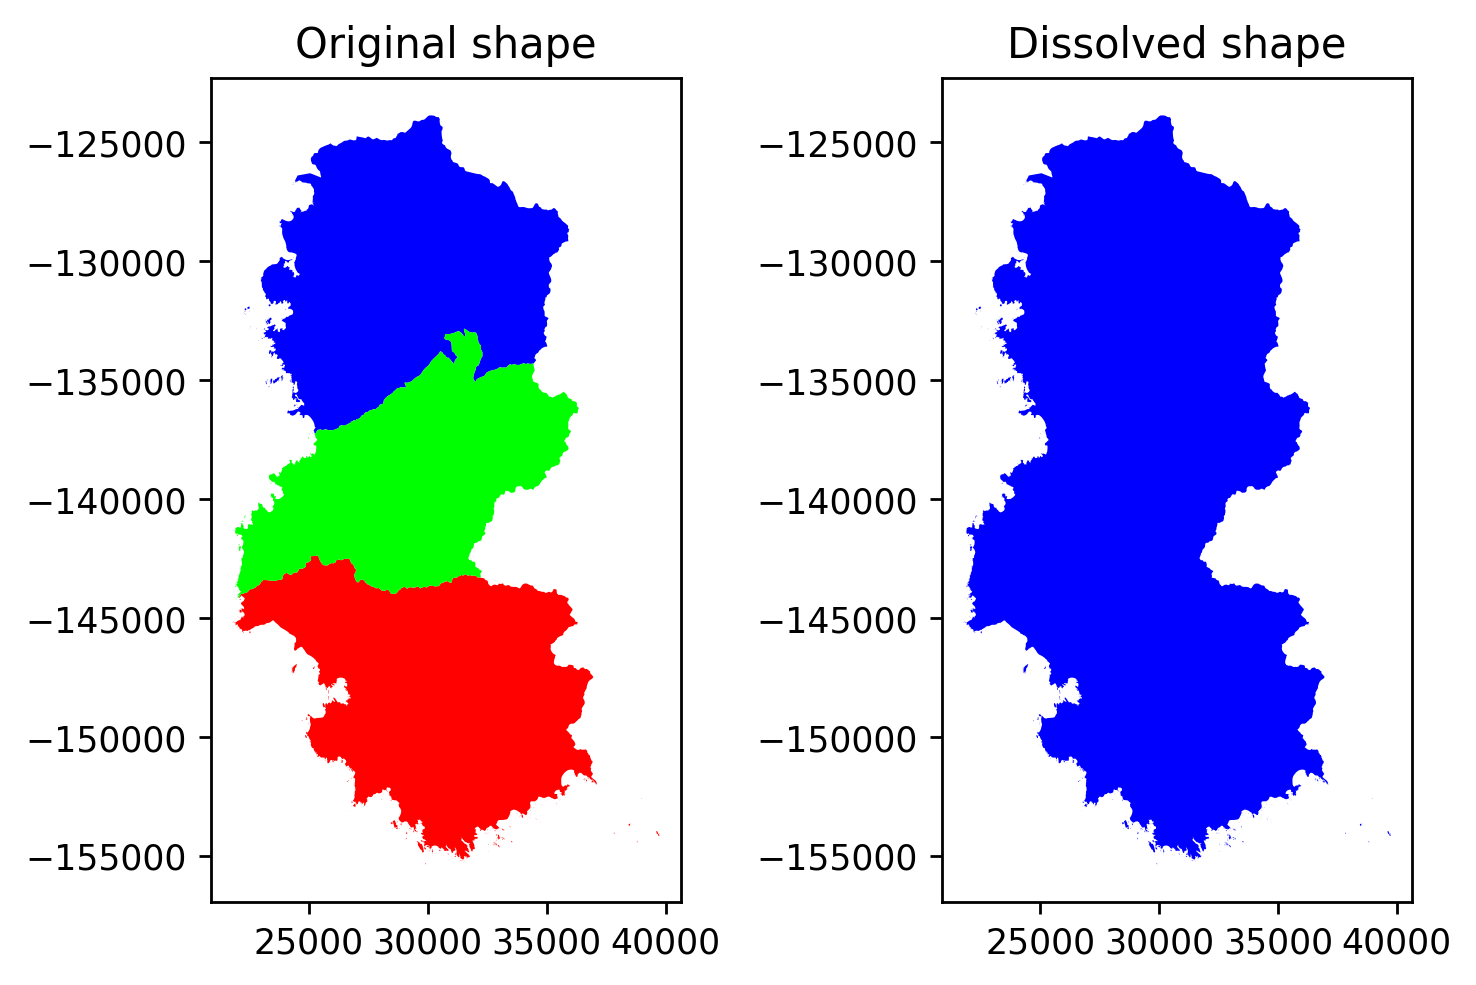

In [ ]:
# 松崎町、南伊豆町、西伊豆町のみを行政界データから抽出抽出
gdfNishiIzu = gdf.loc[(gdf.ATTR_11 == '松崎町')|(gdf.ATTR_11 == '南伊豆町')|(gdf.ATTR_11 == '西伊豆町')]
# gdfNishiIzu

extractedGdf = gdfNishiIzu[['ATTR_7','ATTR_6','geometry']]
extractedGdf = extractedGdf.dissolve(by='ATTR_7',aggfunc='sum')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,12))
gdfNishiIzu.plot(ax=ax1,cmap='brg')
extractedGdf.plot(ax=ax2, cmap='brg')
ax1.set_title('Original shape')
ax2.set_title('Dissolved shape')
plt.tight_layout()
plt.show()

In [ ]:
# 結合した行政界データを保存する（保存場所はマイドライブ以下が望ましい）
extractedGdf.to_file('/content/drive/MyDrive/extractedExtent.geojson',driver='GeoJSON')

In [ ]:
# geodataframeから、座標の最大最小を取得
x_min, y_min, x_max, y_max = extractedGdf.total_bounds
npoints = 1000 # set a sample size

random.seed(42)
allPoints = [(x,y) for x in range(int(x_min),int(x_max),500) for y in range(int(y_min),int(y_max),500)]
samplePoints = np.array(random.sample(allPoints, npoints))

x = samplePoints[:,0]
y = samplePoints[:,1]

# 取得した点ををGeoSeriesへ変換
gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))

# ポリゴン内のデータのみを保持
gdf_points = gdf_points[gdf_points.within(extractedGdf.unary_union)]
gdf_points = gdf_points.sample(n=500) # sample 500 points
print(gdf_points)

984    POINT (24773.000 -128363.000)
182    POINT (27773.000 -143863.000)
504    POINT (28773.000 -149863.000)
111    POINT (30273.000 -144863.000)
315    POINT (30273.000 -140363.000)
                   ...              
890    POINT (33273.000 -137363.000)
940    POINT (29273.000 -147363.000)
367    POINT (29273.000 -127863.000)
612    POINT (27773.000 -140363.000)
483    POINT (31773.000 -128863.000)
Length: 500, dtype: geometry


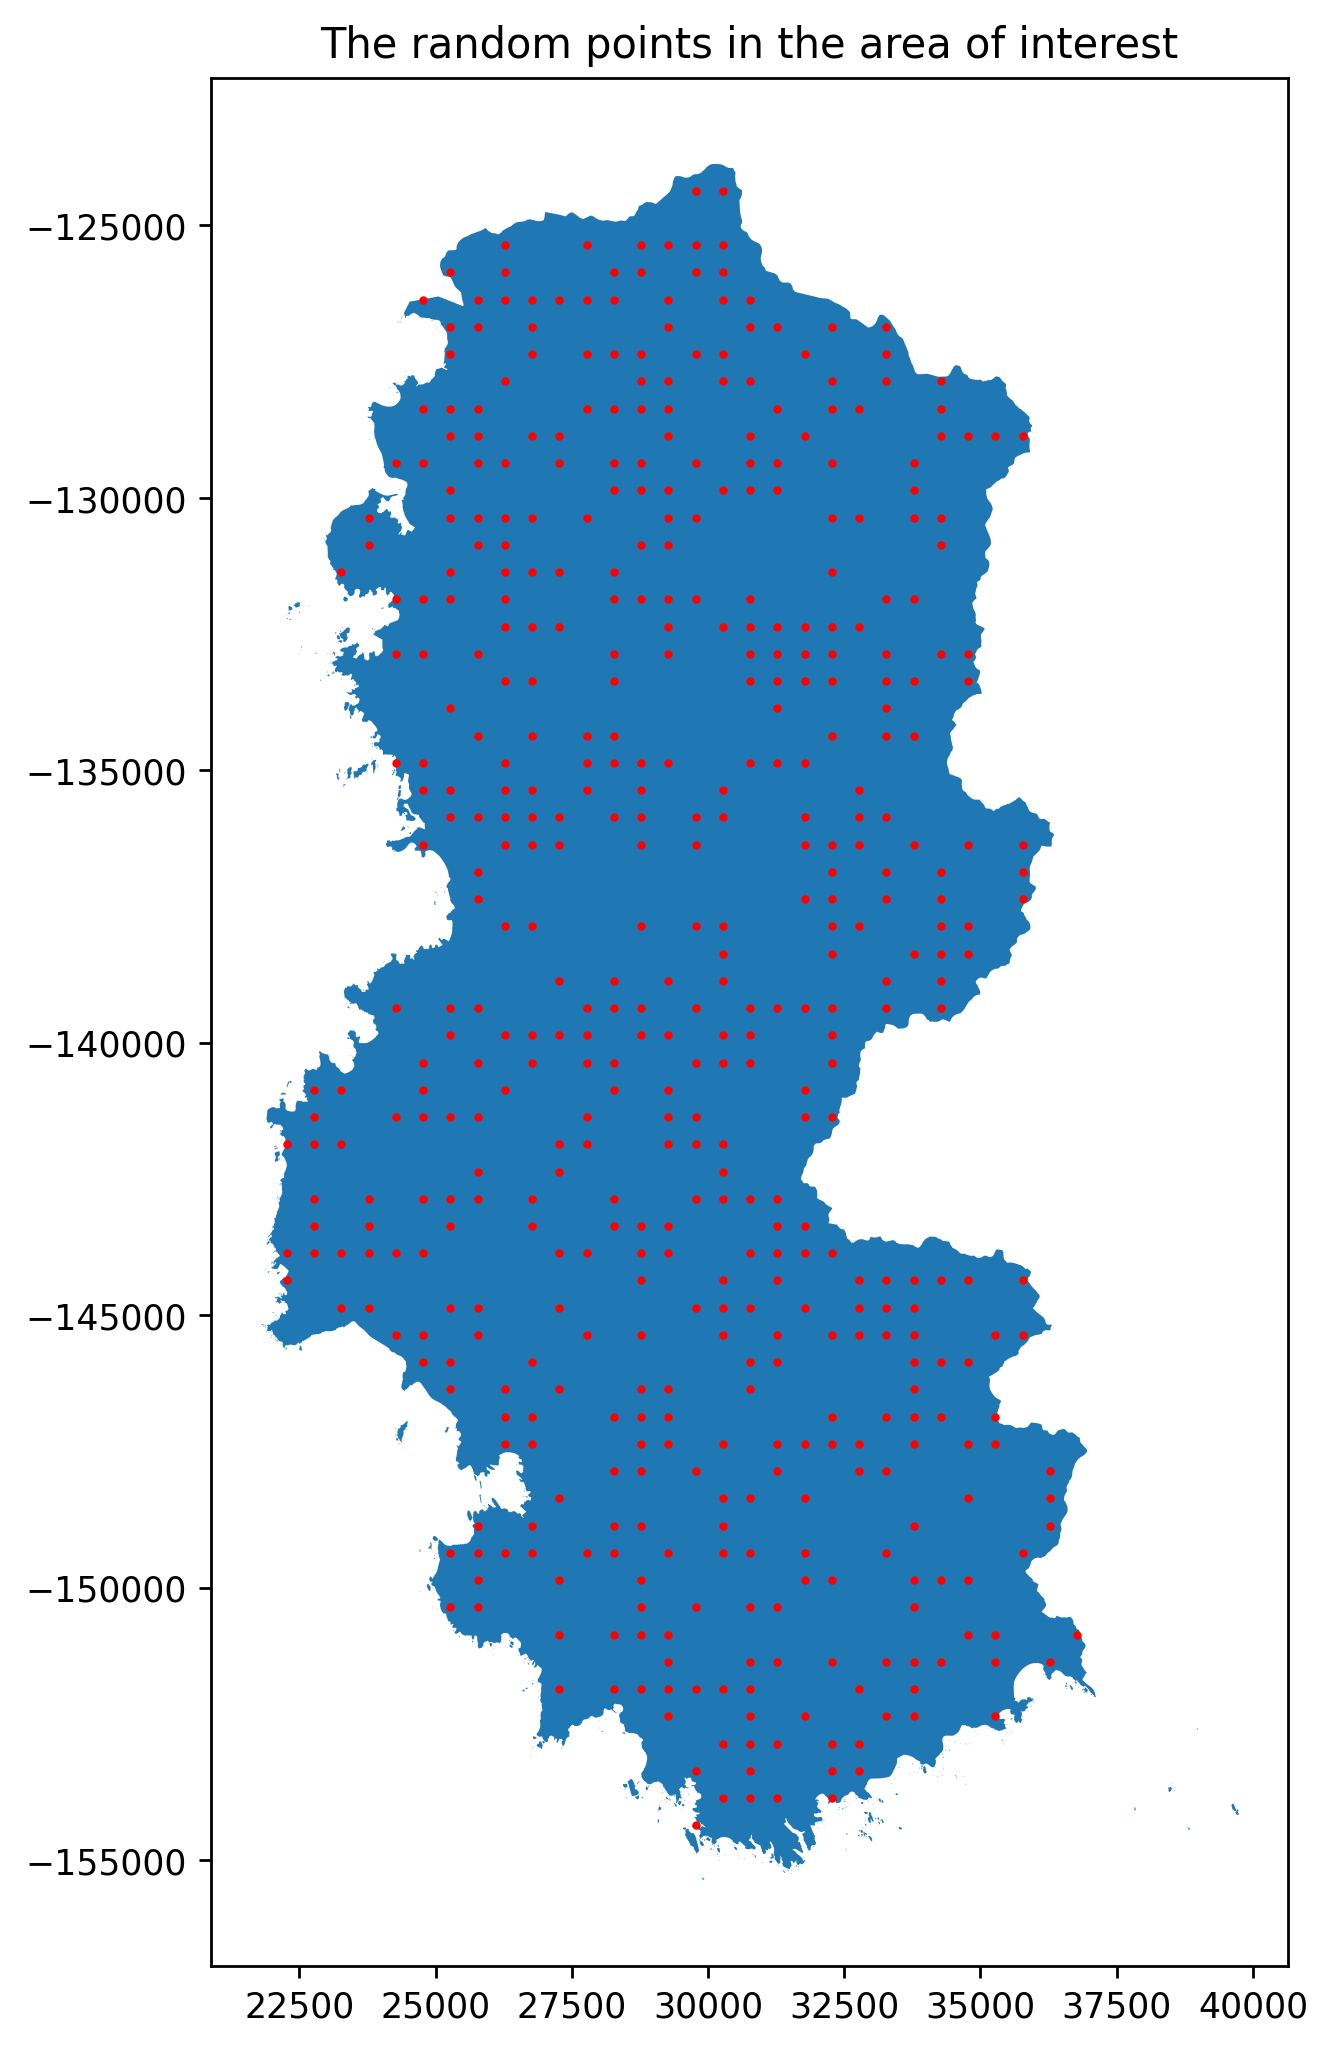

In [ ]:
fig, ax = plt.subplots(figsize=(6,10))
extractedGdf.plot(ax=ax)
gdf_points.plot(ax=ax,color='red',markersize=2)
ax.set_title('The random points in the area of interest')
plt.show()

In [ ]:
# ポイントデータをgpkgとして保存
gdf_points = gdf_points.set_crs('epsg:2450') # set its crs
point_shp = gpd.GeoDataFrame(geometry=gdf_points)
gdf_points.to_file("/content/drive/MyDrive/RandomPoints2450.gpkg", layer='cities', driver="GPKG")

In [ ]:
# S2の画像をクリッピング。加えてCRSの変換も行う行う

def getFeatures(gdf):
    """rasterioで読み取れる形のデータに変換するための関数"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# 画像の読み込み
Rst_red = rxr.open_rasterio(file_url[0],masked=True).squeeze() # B04
Rst_nir = rxr.open_rasterio(file_url[1],masked=True).squeeze() # B08
# print(Rst_red.rio.crs)

# rastrio crsオブジェクトの作成。UTM Zone54NからからJGD2000 CS VIII（平面直角座標第8系）へ変換
jgd2000N8 = CRS.from_string('EPSG:2450')

# 投影変換
Rst_red_jgd = Rst_red.rio.reproject(jgd2000N8)
Rst_nir_jgd = Rst_nir.rio.reproject(jgd2000N8)

# 画像の切り抜き処理
bbox = box(x_min, y_min, x_max, y_max)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(2450))
coords = getFeatures(geo)
# 画像の切り抜き処理
Rst_red_clip = Rst_red_jgd.rio.clip(coords)
Rst_nir_clip = Rst_nir_jgd.rio.clip(coords)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# Rst_red_clip.plot.hist(bins=10) # ピクセルの分布確認用

# 点データとラスタデータをmatplotlibのプロット上に表示する
fig, ax = plt.subplots(figsize=(6,6))
Rst_red_clip.plot.imshow(ax=ax,vmin=0,vmax=Rst_red_clip.quantile(0.95)) # Sentinel-2
point_shp.plot(ax=ax, color='red',markersize=5) # ポイントデータ
ax.set_title('Plot the random points overlayed on the Sentinel image')
ax.set_axis_off()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# NDVIを作成し保存
ndvi_clip = es.normalized_diff(Rst_nir_clip,Rst_red_clip)

# 結果を描画
ep.plot_bands(ndvi_clip,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Sentinel-2 Derived NDVI\n 2 May 2020")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

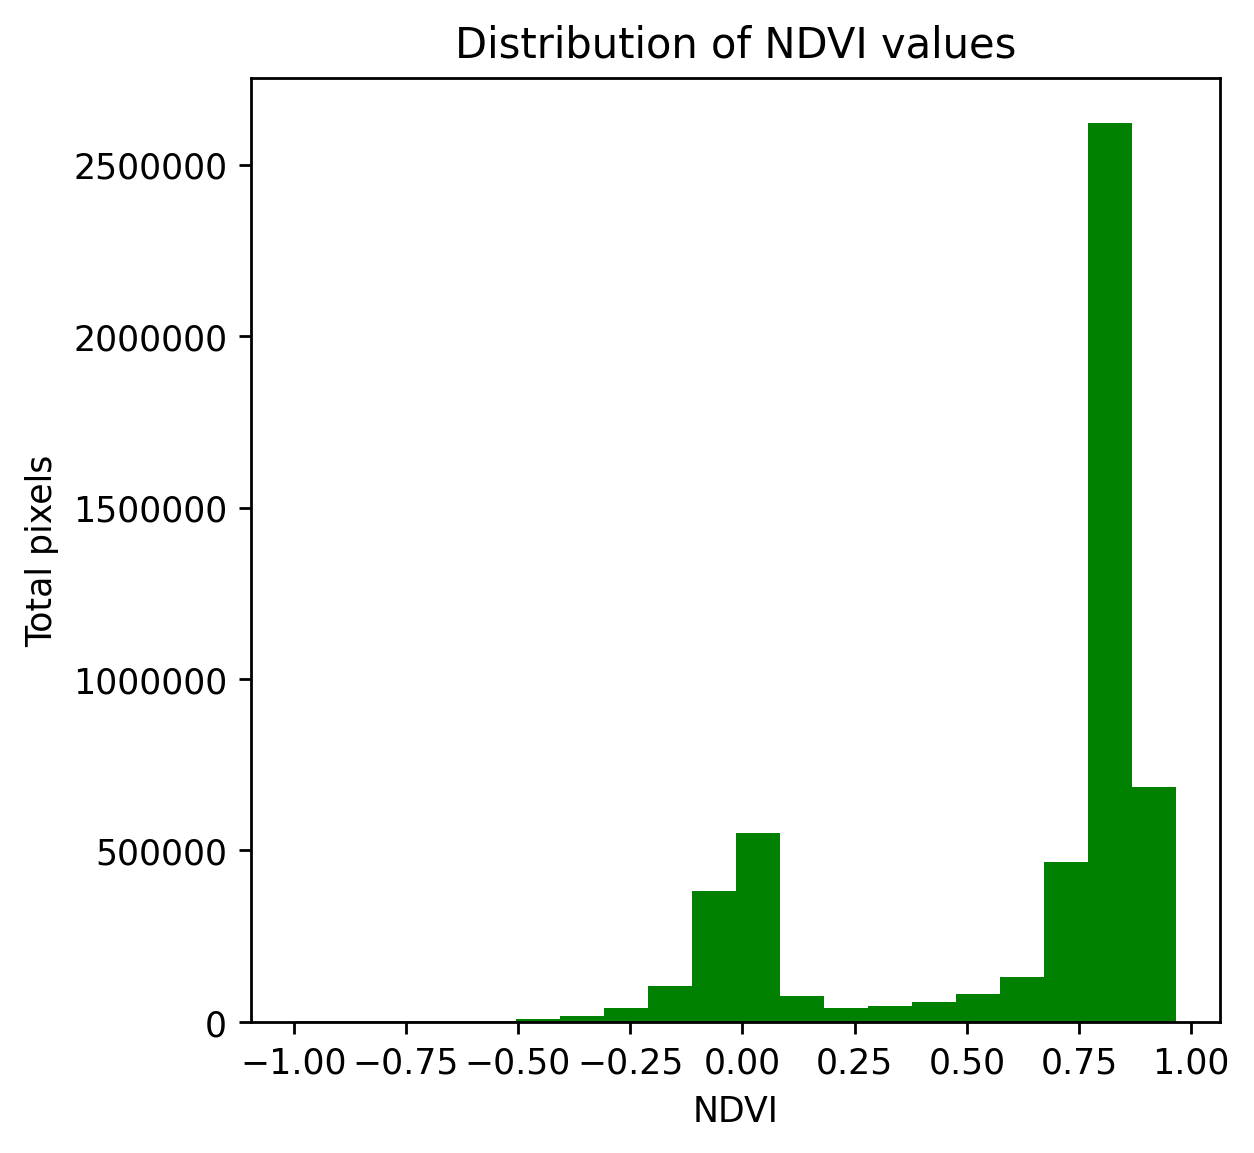

In [ ]:
# ヒストグラム作成
ax = ep.hist(ndvi_clip,
             figsize = (5,5),
             colors = 'green',
             xlabel = 'NDVI',
             ylabel = 'Total pixels',
             title = 'Distribution of NDVI values')

# 見栄え調整
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

In [ ]:
from rasterstats import point_query
ndvi = (Rst_nir_clip - Rst_red_clip)/ (Rst_nir_clip + Rst_red_clip)
# print(ndvi)

pointfile = '/content/drive/MyDrive/RandomPoints2450.gpkg'
gdf_points = gpd.read_file(pointfile)

gdf_points_stats = pd.DataFrame(point_query(gdf_points, ndvi.values, \
                                            affine=ndvi.rio.transform(),nodata=-999))
gdf_points_stats.columns= ['ndvi']
ndvi_stats_df = gdf_points.join(gdf_points_stats)

In [ ]:
ndvi_stats_df

,geometry,ndvi
0,POINT (24773.000 -128363.000),0.860494
1,POINT (27773.000 -143863.000),0.843011
2,POINT (28773.000 -149863.000),0.762226
3,POINT (30273.000 -144863.000),0.754184
4,POINT (30273.000 -140363.000),0.857452
...,...,...
495,POINT (33273.000 -137363.000),0.854899
496,POINT (29273.000 -147363.000),0.783028
497,POINT (29273.000 -127863.000),0.827503
498,POINT (27773.000 -140363.000),0.858840


In [ ]:
# 同様の処理を樹高データに対しても行う

# データの読み込み
tree_resampled = rxr.open_rasterio('/content/drive/MyDrive/IzuResMean.tif',masked=True).squeeze()
tree_resampled_clip = tree_resampled.rio.clip(coords)

# 取得する樹木の高さを制限。最小で0mより高く、最大で40m以下とする
tree_resampled_clip_cont = tree_resampled_clip.where((tree_resampled_clip.values > 0)|(tree_resampled_clip.values <= 40),np.nan)

treeHeight_stats = pd.DataFrame(point_query(gdf_points, tree_resampled_clip_cont.values, \
                                            affine=tree_resampled_clip_cont.rio.transform(),nodata=-999))
treeHeight_stats.columns= ['tree_height']
treeHeight_stats_df = gdf_points.join(treeHeight_stats)

In [ ]:
print("the minimum raster value is: ", np.nanmin(treeHeight_stats.values))
print("the maximum raster value is: ", np.nanmax(treeHeight_stats.values))

the minimum raster value is:  0.1691405302286181
the maximum raster value is:  30.366986846926817


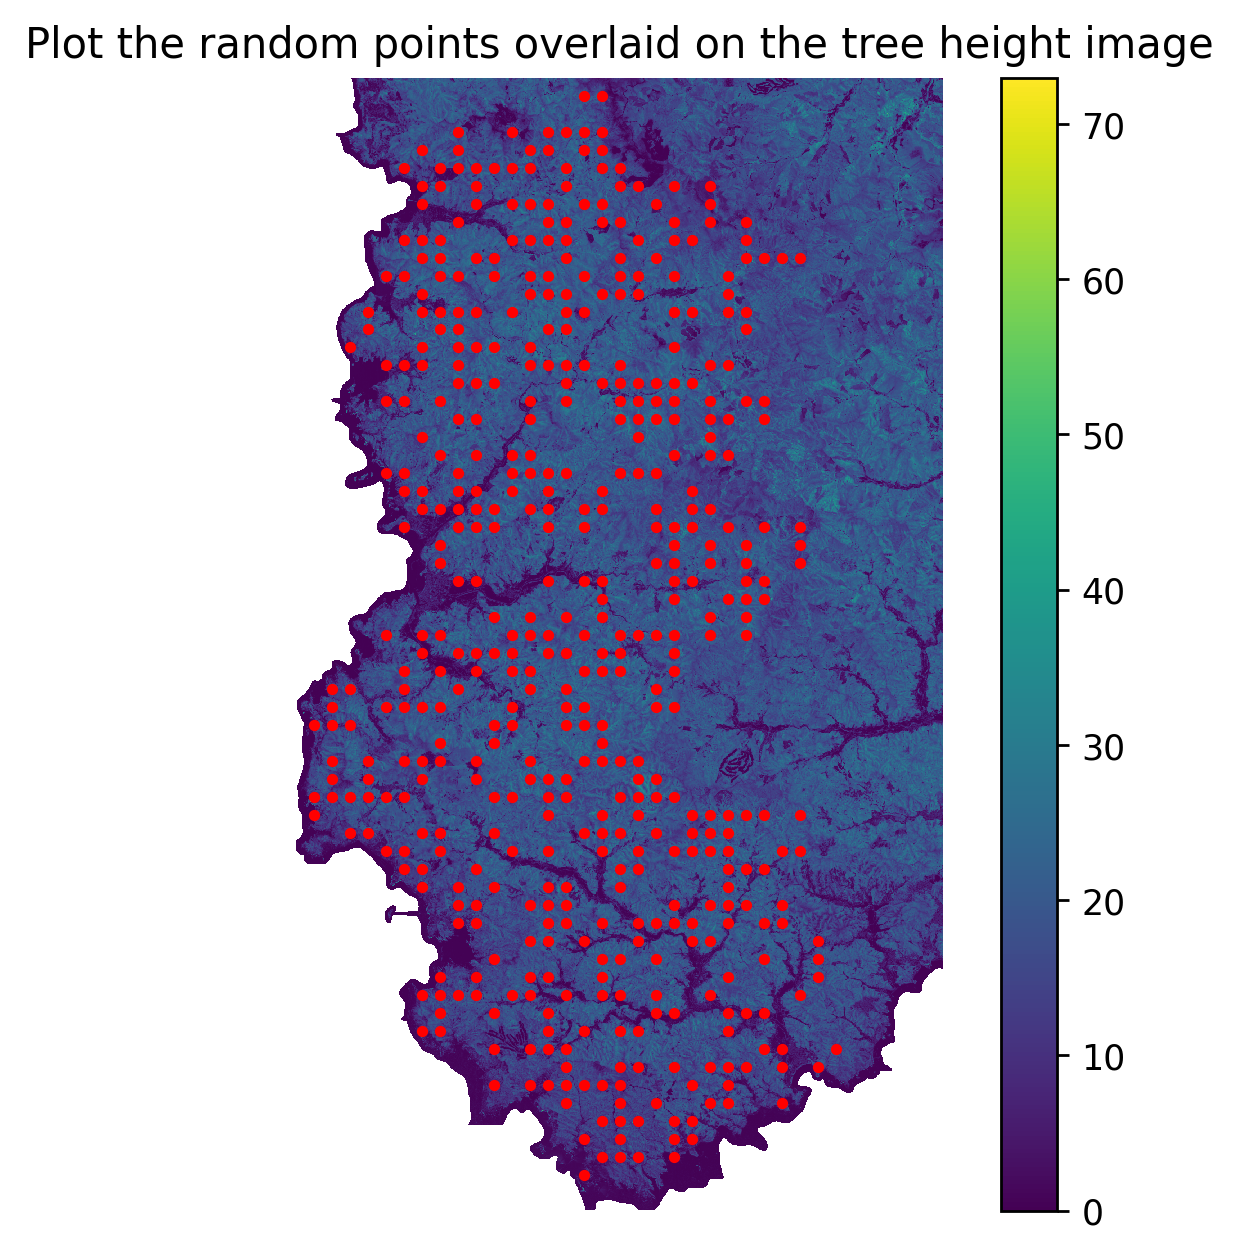

In [ ]:
# 点データとラスタデータをmatplotlibのプロット上に表示する
fig, ax = plt.subplots(figsize=(6,6))
tree_resampled_clip.plot.imshow(ax=ax)
point_shp.plot(ax=ax, color='red',markersize=5) # ポイントデータ
ax.set_title('Plot the random points overlaid on the tree height image')
ax.set_axis_off()
plt.show()

In [ ]:
# 二つのデータフレームを結合
combinedData = ndvi_stats_df.merge(treeHeight_stats_df, on='geometry')
combinedData = combinedData.dropna()

combinedData.head()

,geometry,ndvi,tree_height
0,POINT (24773.000 -128363.000),0.860494,19.980115
1,POINT (27773.000 -143863.000),0.843011,14.817871
2,POINT (28773.000 -149863.000),0.762226,19.528136
3,POINT (30273.000 -144863.000),0.754184,19.713546
4,POINT (30273.000 -140363.000),0.857452,19.008990


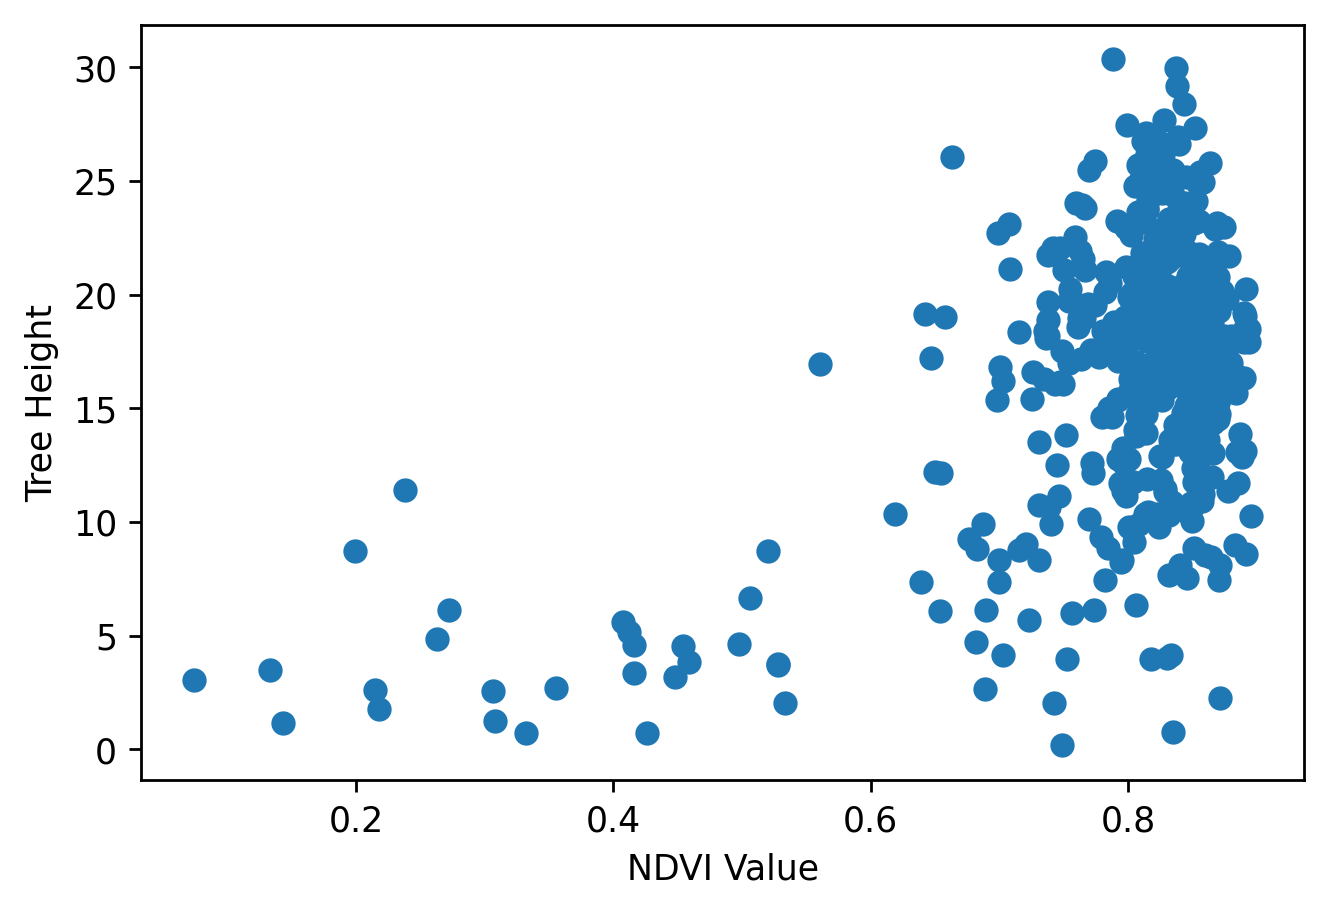

In [ ]:
# データの作図
x = combinedData['ndvi']
y = combinedData['tree_height']

plt.xlabel('NDVI Value')
plt.ylabel('Tree Height')
plt.plot(x, y, 'o')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# データセットをトレーニングデータとテストデータに分割
X = np.array(combinedData['ndvi']).reshape(-1,1)
y = np.array(combinedData['tree_height']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# shapeを使って次元を確認
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 1) (100, 1) (400, 1) (100, 1)


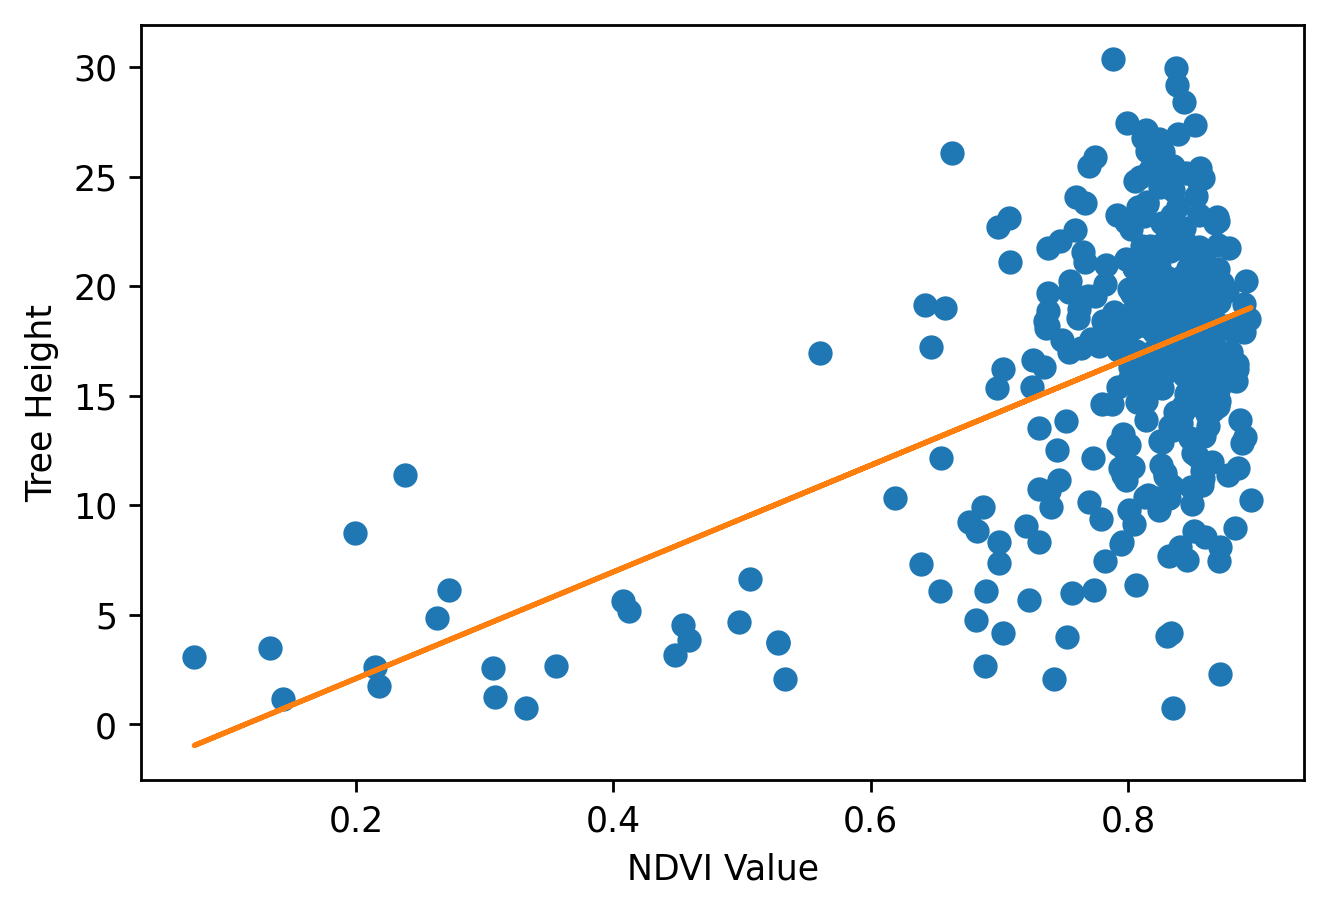

In [ ]:
# LinearRegressionクラスのインスタンスを生成
lreg = LinearRegression()
# トレーニング用データを使ってトレーニング
lreg.fit(X_train, y_train)

plt.xlabel('NDVI Value')
plt.ylabel('Tree Height')
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, lreg.predict(X_train), linestyle="solid")
plt.show()

In [ ]:
print('y= %.3fx + %.3f' % (lreg.coef_ , lreg.intercept_)) # モデル式
print('決定係数 R^2： ', round(lreg.score(X_train, y_train),2)) # 決定係数によりモデルの当てはまりの良さを確認する

y= 24.334x + -2.771
決定係数 R^2：  0.27


In [ ]:
# 訓練データと正解データでモデルの精度を確かめる
from sklearn import metrics
from math import sqrt

y_pred = lreg.predict(X_test)
testR2 = round(metrics.r2_score(y_test,y_pred), 2)
print('決定係数 R^2： ', testR2)

## 平均二乗誤差の確認確認
# print('X_testを使ったモデルの平均二乗誤差＝{:0.2f}'.format(np.mean((y_test - y_pred) ** 2))) # MSE
# RMSE
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('RMSE: ', round(rmse,2))

決定係数 R^2：  0.21
RMSE:  4.77
